In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import statsmodels.api as sm

In [2]:
data_2017 = pd.read_csv('dataset/data_2017.csv')[['state_name', 'median_income', 'hate_crime_case_normalized']]
data_2018 = pd.read_csv('dataset/data_2018.csv')[['state_name', 'median_income', 'hate_crime_case_normalized']]
data_2019 = pd.read_csv('dataset/data_2019.csv')[['state_name', 'median_income', 'hate_crime_case_normalized']]
data_2020 = pd.read_csv('dataset/data_2020.csv')[['state_name', 'median_income', 'hate_crime_case_normalized']]
data_2021 = pd.read_csv('dataset/data_2021.csv')[['state_name', 'median_income', 'hate_crime_case_normalized']]

In [3]:
df = pd.read_excel('hate_crime_dataset.xlsx')
df = df.groupby(['data_year', 'state_name']).agg(hate_crime_case = ('state_name', 'size'))
agg_data = pd.DataFrame(df).reset_index()

# 연도별 혐오 범죄 수
case_2017 = agg_data[agg_data['data_year'] == 2017].drop(['data_year'], axis=1)
case_2018 = agg_data[agg_data['data_year'] == 2018].drop(['data_year'], axis=1)
case_2019 = agg_data[agg_data['data_year'] == 2019].drop(['data_year'], axis=1)
case_2020 = agg_data[agg_data['data_year'] == 2020].drop(['data_year'], axis=1)
case_2021 = agg_data[agg_data['data_year'] == 2021].drop(['data_year'], axis=1)

mdata_2017 = pd.merge(data_2017, case_2017, on='state_name')
mdata_2018 = pd.merge(data_2018, case_2018, on='state_name')
mdata_2019 = pd.merge(data_2019, case_2019, on='state_name')
mdata_2020 = pd.merge(data_2020, case_2020, on='state_name')
mdata_2021 = pd.merge(data_2021, case_2021, on='state_name')

# # 연도별 gini(소득 불평등을 나타내는 지표)
# gini_2017 = pd.read_excel('dataset/gini_2017.xlsx')[['state_name', 'gini']]
# gini_2018 = pd.read_excel('dataset/gini_2018.xlsx')[['state_name', 'gini']]
# gini_2019 = pd.read_excel('dataset/gini_2019.xlsx')[['state_name', 'gini']]
# gini_2020 = pd.read_excel('dataset/gini_2020.xlsx')[['state_name', 'gini']]
# gini_2021 = pd.read_excel('dataset/gini_2021.xlsx')[['state_name', 'gini']]

# 연도별 gini(소득 불평등을 나타내는 지표)
gini_2017 = pd.read_excel('dataset/new_gini_2017.xlsx')[['state_name', 'gini']]
gini_2018 = pd.read_excel('dataset/new_gini_2018.xlsx')[['state_name', 'gini']]
gini_2019 = pd.read_excel('dataset/new_gini_2019.xlsx')[['state_name', 'gini']]
gini_2020 = pd.read_excel('dataset/new_gini_2020.xlsx')[['state_name', 'gini']]
gini_2021 = pd.read_excel('dataset/new_gini_2021.xlsx')[['state_name', 'gini']]

mdata_2017 = pd.merge(mdata_2017, gini_2017, on='state_name')
mdata_2018 = pd.merge(mdata_2018, gini_2018, on='state_name')
mdata_2019 = pd.merge(mdata_2019, gini_2019, on='state_name')
mdata_2020 = pd.merge(mdata_2020, gini_2020, on='state_name')
mdata_2021 = pd.merge(mdata_2021, gini_2021, on='state_name')

# 연도별 인구 수
pop_2017 = pd.read_csv('dataset/pop_df_2017.csv').drop(['Year'], axis=1)
pop_2018 = pd.read_csv('dataset/pop_df_2018.csv').drop(['Year'], axis=1)
pop_2019 = pd.read_csv('dataset/pop_df_2019.csv').drop(['Year'], axis=1)
pop_2020 = pd.read_csv('dataset/pop_df_2020.csv').drop(['Year'], axis=1)
pop_2021 = pd.read_csv('dataset/pop_df_2021.csv')

# Convert 'nnn,nnn,nnn'(type: object) into nnnnnnnnn(type: int64) 
for i in range(len(pop_2021)):
    pop_2021.loc[i, 'Population'] = pop_2021['Population'].values[i].replace(",", "")
pop_2021 = pop_2021.astype({'Population':'int'})

pops = [pop_2017, pop_2018, pop_2019, pop_2020, pop_2021]
for dataframe in pops:
    dataframe.columns = ['state_name', 'population']
    
mdata_2017 = pd.merge(mdata_2017, pop_2017, on='state_name')
mdata_2018 = pd.merge(mdata_2018, pop_2018, on='state_name')
mdata_2019 = pd.merge(mdata_2019, pop_2019, on='state_name')
mdata_2020 = pd.merge(mdata_2020, pop_2020, on='state_name')
mdata_2021 = pd.merge(mdata_2021, pop_2021, on='state_name')

mdata_all = pd.concat([mdata_2017, mdata_2018, mdata_2019, mdata_2020, mdata_2021])

# 선형 회귀 분석 (Linear Regression)

### 1. 주 중간 소득(X)과 인구 대비 범죄 발생률(Y) 사이 상관 관계

중간 소득(median_income)에 따라 인구 대비 범죄 발생률(hate_crime_case_normalized)가 어떻게 변화하는지,</br>
OLS 모델을 사용하여 선형 회귀 분석을 수행함.

\* 코드 참조: statsmodel 공식 document

In [4]:
# 연도별 데이터를 통합 후 median_income에 따라 정렬
data_all = pd.concat([data_2017, data_2018, data_2019, data_2020, data_2021])
data_all.sort_values(by='median_income', ignore_index=True, inplace=True)

In [5]:
X = data_all['median_income']
y = data_all['hate_crime_case_normalized']

# OLS 모델을 따라 선형 회귀 분석 수행
results = sm.OLS(y, X).fit()
print(results.summary())

                                     OLS Regression Results                                    
Dep. Variable:     hate_crime_case_normalized   R-squared (uncentered):                   0.458
Model:                                    OLS   Adj. R-squared (uncentered):              0.455
Method:                         Least Squares   F-statistic:                              212.5
Date:                        Sat, 03 Jun 2023   Prob (F-statistic):                    2.52e-35
Time:                                21:30:37   Log-Likelihood:                         -1255.5
No. Observations:                         253   AIC:                                      2513.
Df Residuals:                             252   BIC:                                      2517.
Df Model:                                   1                                                  
Covariance Type:                    nonrobust                                                  
                    coef    std err     

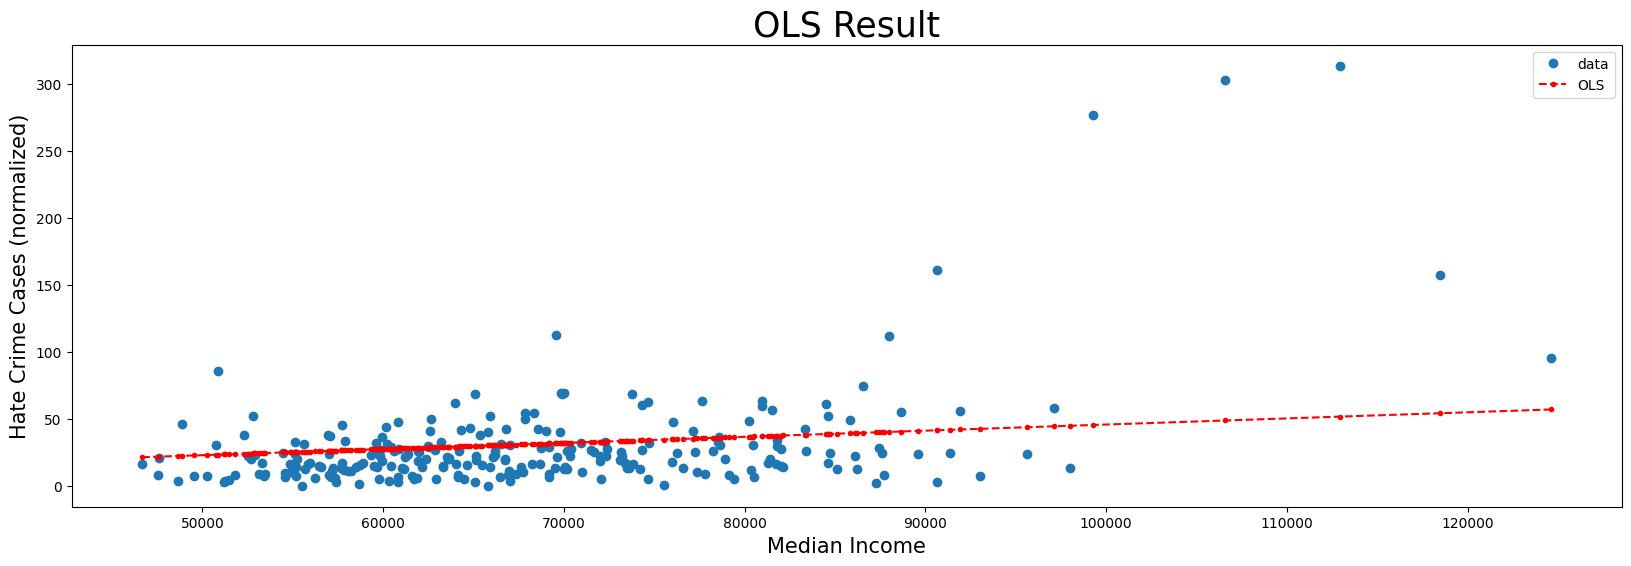

In [6]:
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(X, y, "o", label="data")
ax.plot(X, results.fittedvalues, "r--.", label="OLS")
ax.legend(loc="best")

plt.xlabel('Median Income', size=15)
plt.ylabel('Hate Crime Cases (normalized)', size=15)
plt.title('OLS Result', size=25)
plt.show()

### 2. 주 중간 소득(X)과 인구 대비 범죄 발생률(Y) 사이 상관 관계 - D.C 제거

미국의 수도인 **Washington D.C**의 경우 타 주에 비해 중간 소득과 인구 대비 범죄 발생률 모두 지나치게 높은 특징을 보이는 이상치(outlier)이므로,</br> D.C.를 제외하고 선형 회귀 분석을 재수행함.

수행 결과 R-squared 값이 0.17 향상됨.

In [7]:
data_all_refined = data_all.iloc[:248]

X = data_all_refined['median_income']
y = data_all_refined['hate_crime_case_normalized']

# OLS 모델을 따라 선형 회귀 분석 수행
results = sm.OLS(y, X).fit()
print(results.summary())

                                     OLS Regression Results                                    
Dep. Variable:     hate_crime_case_normalized   R-squared (uncentered):                   0.628
Model:                                    OLS   Adj. R-squared (uncentered):              0.626
Method:                         Least Squares   F-statistic:                              416.4
Date:                        Sat, 03 Jun 2023   Prob (F-statistic):                    6.51e-55
Time:                                21:30:38   Log-Likelihood:                         -1090.7
No. Observations:                         248   AIC:                                      2183.
Df Residuals:                             247   BIC:                                      2187.
Df Model:                                   1                                                  
Covariance Type:                    nonrobust                                                  
                    coef    std err     

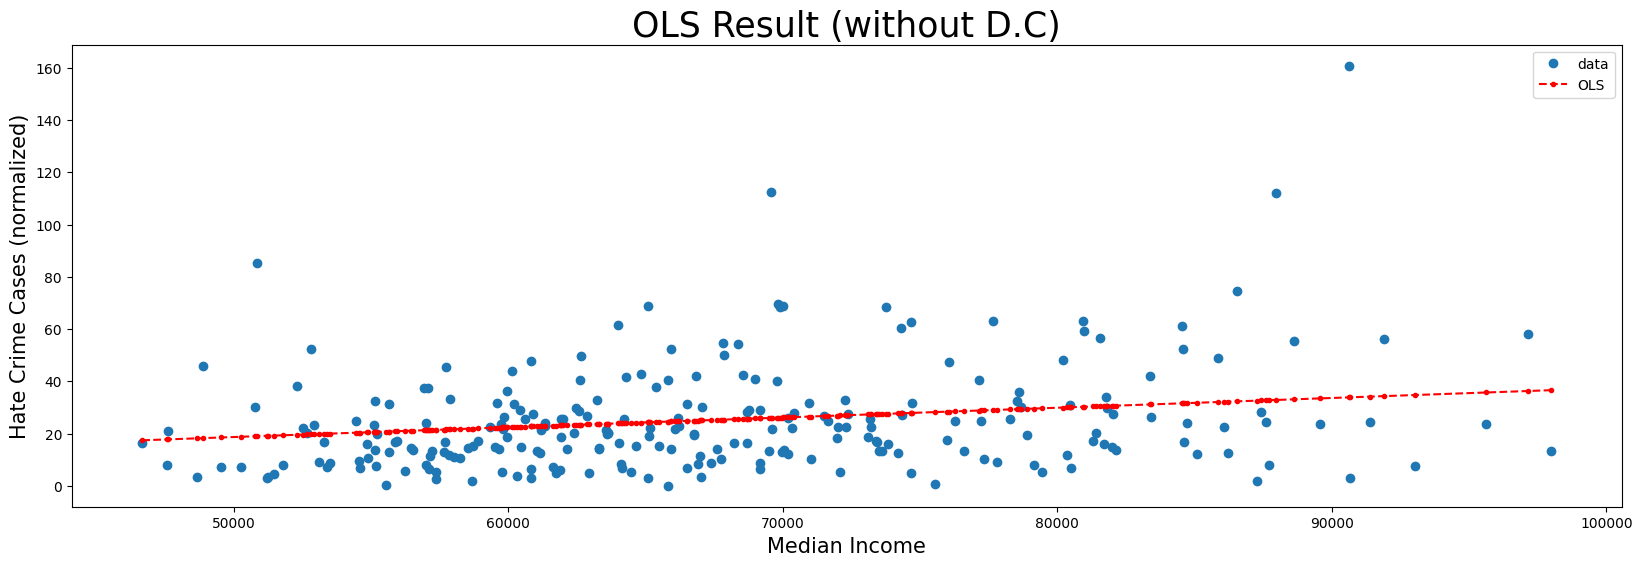

In [8]:
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(X, y, "o", label="data")
ax.plot(X, results.fittedvalues, "r--.", label="OLS")
ax.legend(loc="best")

plt.xlabel('Median Income', size=15)
plt.ylabel('Hate Crime Cases (normalized)', size=15)
plt.title('OLS Result (without D.C)', size=25)
plt.show()

### 3. 주 소득 격차(X)와 인구 대비 범죄 발생률(Y) 사이 상관 관계

In [9]:
mdata_gsort = mdata_all.sort_values(by='gini', ignore_index=True)

X = mdata_gsort['gini']
y = mdata_gsort['hate_crime_case_normalized']

# OLS 모델을 따라 선형 회귀 분석 수행
results = sm.OLS(y, X).fit()
print(results.summary())

                                     OLS Regression Results                                    
Dep. Variable:     hate_crime_case_normalized   R-squared (uncentered):                   0.378
Model:                                    OLS   Adj. R-squared (uncentered):              0.375
Method:                         Least Squares   F-statistic:                              153.0
Date:                        Sat, 03 Jun 2023   Prob (F-statistic):                    8.81e-28
Time:                                21:30:38   Log-Likelihood:                         -1272.8
No. Observations:                         253   AIC:                                      2548.
Df Residuals:                             252   BIC:                                      2551.
Df Model:                                   1                                                  
Covariance Type:                    nonrobust                                                  
                 coef    std err        

### 4. 주 소득 격차(X)와 인구 대비 범죄 발생률(Y) 사이 상관 관계 (D.C. 제거)

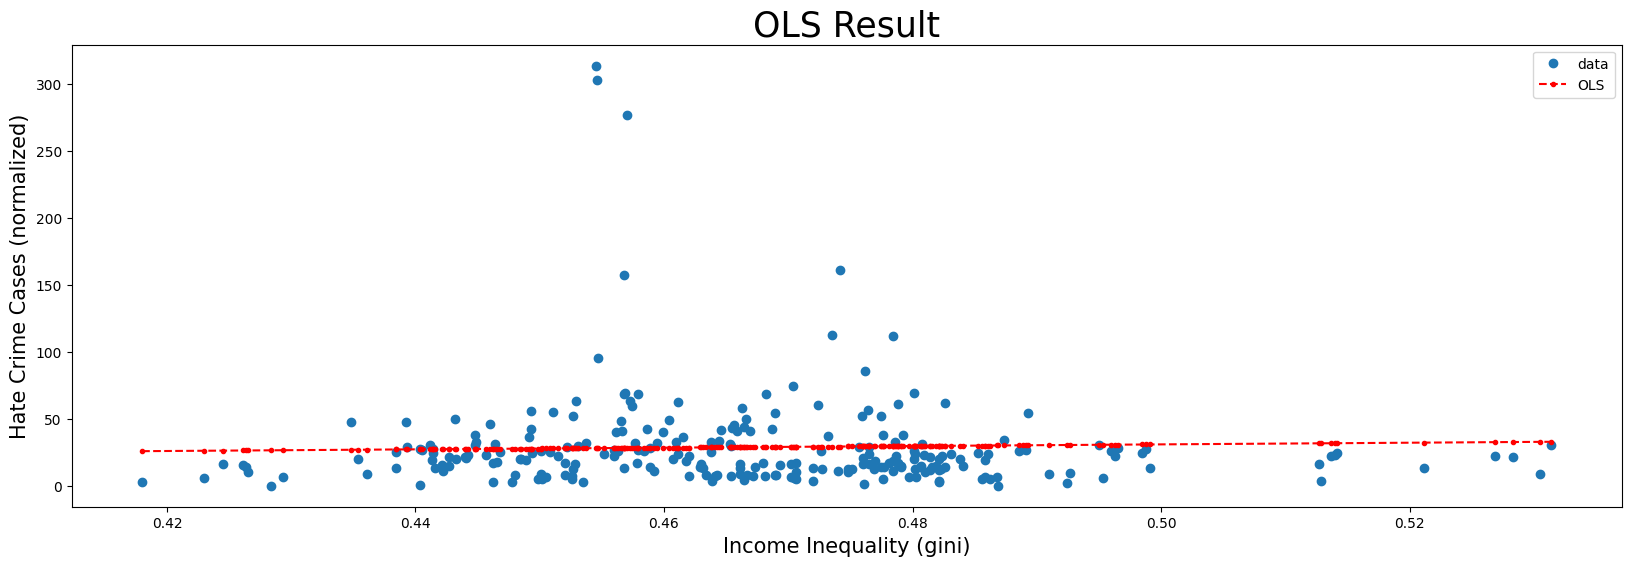

In [10]:
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(X, y, "o", label="data")
ax.plot(X, results.fittedvalues, "r--.", label="OLS")
ax.legend(loc="best")

plt.xlabel('Income Inequality (gini)', size=15)
plt.ylabel('Hate Crime Cases (normalized)', size=15)
plt.title('OLS Result', size=25)
plt.show()

                                     OLS Regression Results                                    
Dep. Variable:     hate_crime_case_normalized   R-squared (uncentered):                   0.598
Model:                                    OLS   Adj. R-squared (uncentered):              0.597
Method:                         Least Squares   F-statistic:                              367.7
Date:                        Sat, 03 Jun 2023   Prob (F-statistic):                    8.25e-51
Time:                                23:19:19   Log-Likelihood:                         -1100.1
No. Observations:                         248   AIC:                                      2202.
Df Residuals:                             247   BIC:                                      2206.
Df Model:                                   1                                                  
Covariance Type:                    nonrobust                                                  
                 coef    std err        

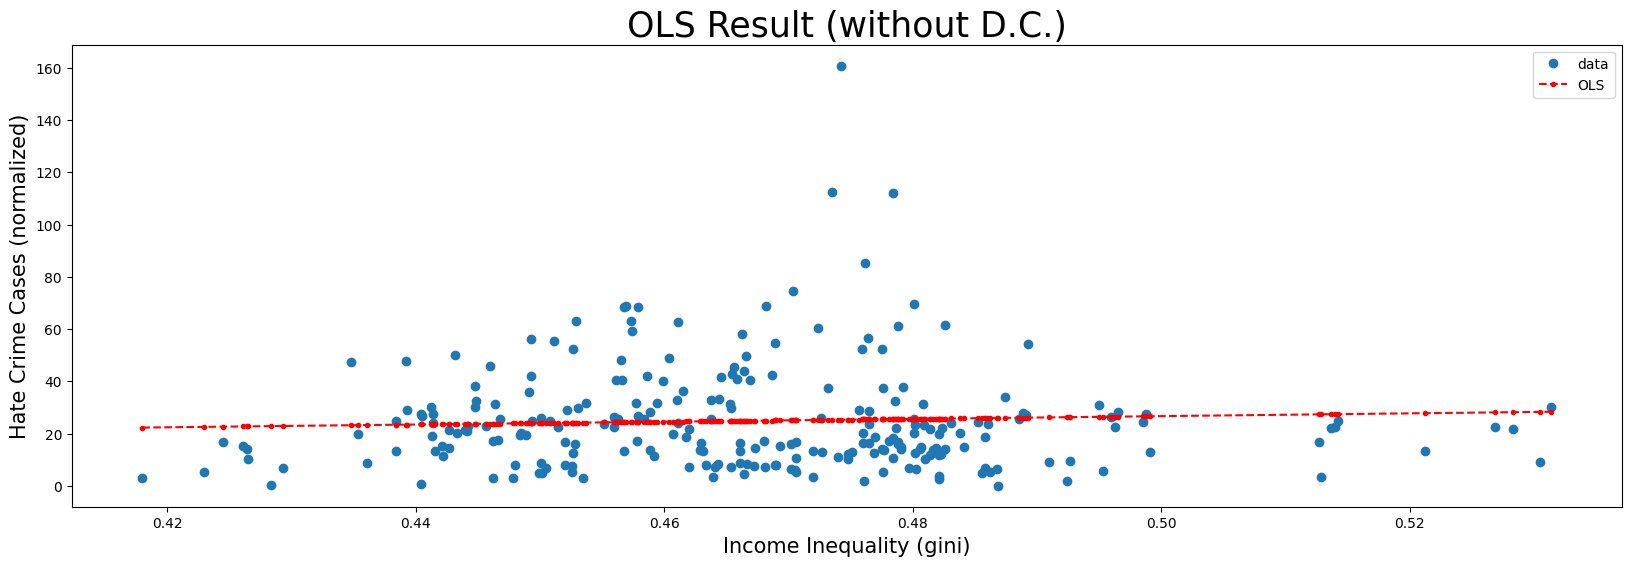

In [60]:
mdata_gsort = mdata_all.sort_values(by='gini', ignore_index=True)
mdata_gsort.drop(mdata_gsort[(mdata_gsort['state_name'] == "District of Columbia")].index, inplace=True)

X = mdata_gsort['gini']
# X = sm.add_constant(X)
y = mdata_gsort['hate_crime_case_normalized']

# OLS 모델을 따라 선형 회귀 분석 수행
results = sm.OLS(y, X).fit()
print(results.summary())

fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(X, y, "o", label="data")
ax.plot(X, results.fittedvalues, "r--.", label="OLS")
ax.legend(loc="best")

plt.xlabel('Income Inequality (gini)', size=15)
plt.ylabel('Hate Crime Cases (normalized)', size=15)
plt.title('OLS Result (without D.C.)', size=25)
plt.show()

### 5. Interaction

In [11]:
mdata_all['income*gini'] = mdata_all['median_income'] * mdata_all['gini']

mdata_isort = mdata_all.sort_values(by='income*gini', ignore_index=True)

X = mdata_isort['income*gini']
# X = sm.add_constant(X)
y = mdata_isort['hate_crime_case_normalized']

# OLS 모델을 따라 선형 회귀 분석 수행
results = sm.OLS(y, X).fit()
print(results.summary())

                                     OLS Regression Results                                    
Dep. Variable:     hate_crime_case_normalized   R-squared (uncentered):                   0.453
Model:                                    OLS   Adj. R-squared (uncentered):              0.451
Method:                         Least Squares   F-statistic:                              208.5
Date:                        Sat, 03 Jun 2023   Prob (F-statistic):                    7.62e-35
Time:                                21:30:38   Log-Likelihood:                         -1256.6
No. Observations:                         253   AIC:                                      2515.
Df Residuals:                             252   BIC:                                      2519.
Df Model:                                   1                                                  
Covariance Type:                    nonrobust                                                  
                  coef    std err       

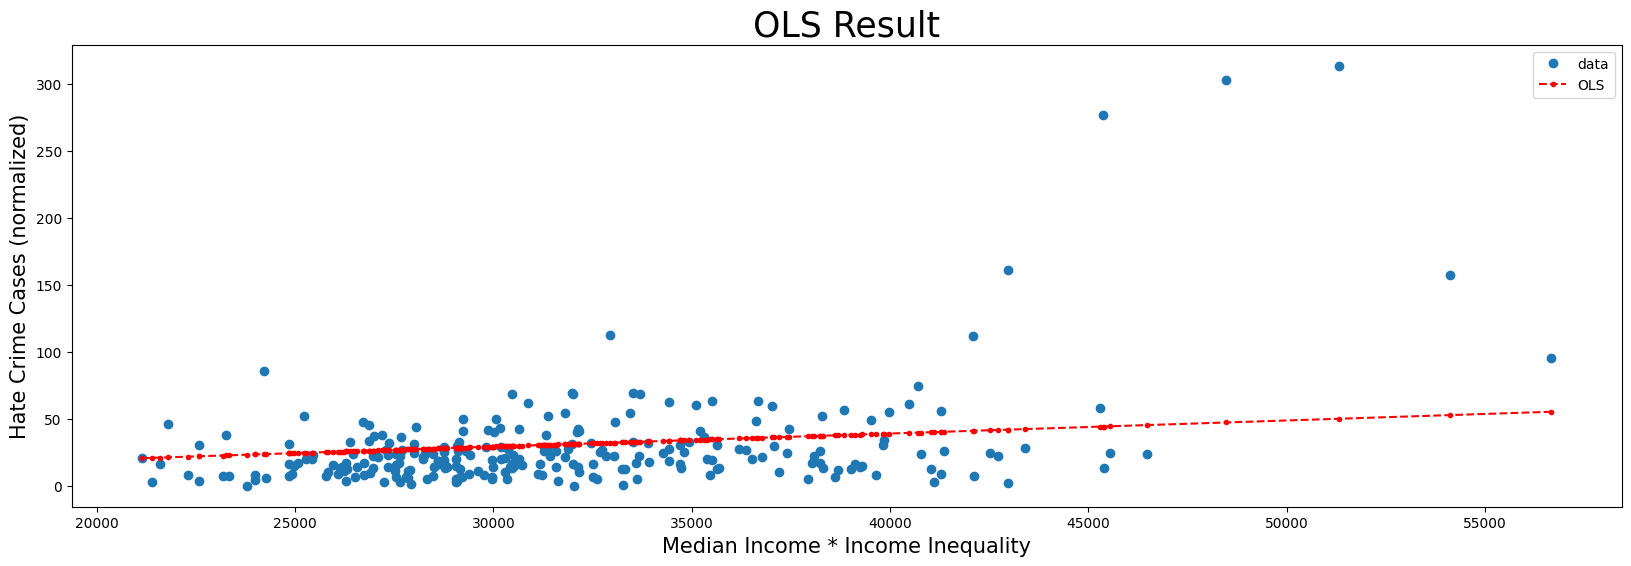

In [12]:
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(X, y, "o", label="data")
ax.plot(X, results.fittedvalues, "r--.", label="OLS")
ax.legend(loc="best")

plt.xlabel('Median Income * Income Inequality', size=15)
plt.ylabel('Hate Crime Cases (normalized)', size=15)
plt.title('OLS Result', size=25)
plt.show()

### 6. Interaction (without D.C)

In [13]:
mdata_all['income*gini'] = mdata_all['median_income'] * mdata_all['gini']

mdata_isort = mdata_all.sort_values(by='income*gini', ignore_index=True)
mdata_isort.drop(mdata_isort[(mdata_isort['state_name'] == "District of Columbia")].index, inplace=True)

X = mdata_isort['income*gini']
# X = sm.add_constant(X)
y = mdata_isort['hate_crime_case_normalized']

# OLS 모델을 따라 선형 회귀 분석 수행
results = sm.OLS(y, X).fit()
print(results.summary())

                                     OLS Regression Results                                    
Dep. Variable:     hate_crime_case_normalized   R-squared (uncentered):                   0.626
Model:                                    OLS   Adj. R-squared (uncentered):              0.625
Method:                         Least Squares   F-statistic:                              413.8
Date:                        Sat, 03 Jun 2023   Prob (F-statistic):                    1.06e-54
Time:                                21:30:38   Log-Likelihood:                         -1091.2
No. Observations:                         248   AIC:                                      2184.
Df Residuals:                             247   BIC:                                      2188.
Df Model:                                   1                                                  
Covariance Type:                    nonrobust                                                  
                  coef    std err       

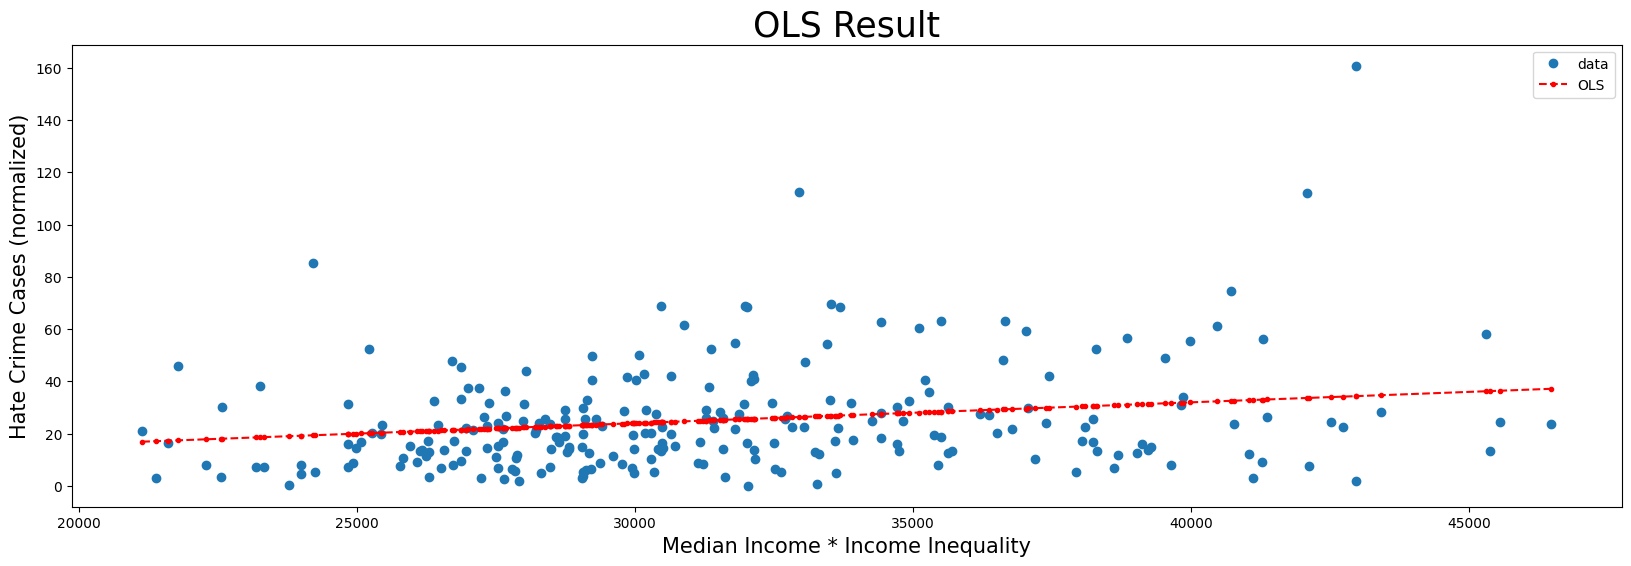

In [14]:
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(X, y, "o", label="data")
ax.plot(X, results.fittedvalues, "r--.", label="OLS")
ax.legend(loc="best")

plt.xlabel('Median Income * Income Inequality', size=15)
plt.ylabel('Hate Crime Cases (normalized)', size=15)
plt.title('OLS Result', size=25)
plt.show()

## 다중 선형 회귀 (Multiple Linear Regression)

주별 인구 수, 중간 소득, 소득 격차를 가지고 선형 회귀 분석 수행

### 1. 다중공선성 확인

**ScatterPlot**, **VIF**(Variance Inflation Factor)를 통한 독립변수의 다중공선성 확인

경우에 따라 다르지만 statsmodel document에서는 **VIF 5 이상일 경우 다중공선성이 요인이 된다**고 판단하기를 추천함

* median_income과 gini는 높은 다중공선성을 갖는 것으로 확인됨

In [28]:
mdata_all[['median_income', 'gini', 'income*gini', 'population']].corr()

,median_income,gini,income*gini,population
median_income,1.000000,-0.079132,0.973563,0.044377
gini,-0.079132,1.000000,0.147703,0.152799
income*gini,0.973563,0.147703,1.000000,0.081208
population,0.044377,0.152799,0.081208,1.000000


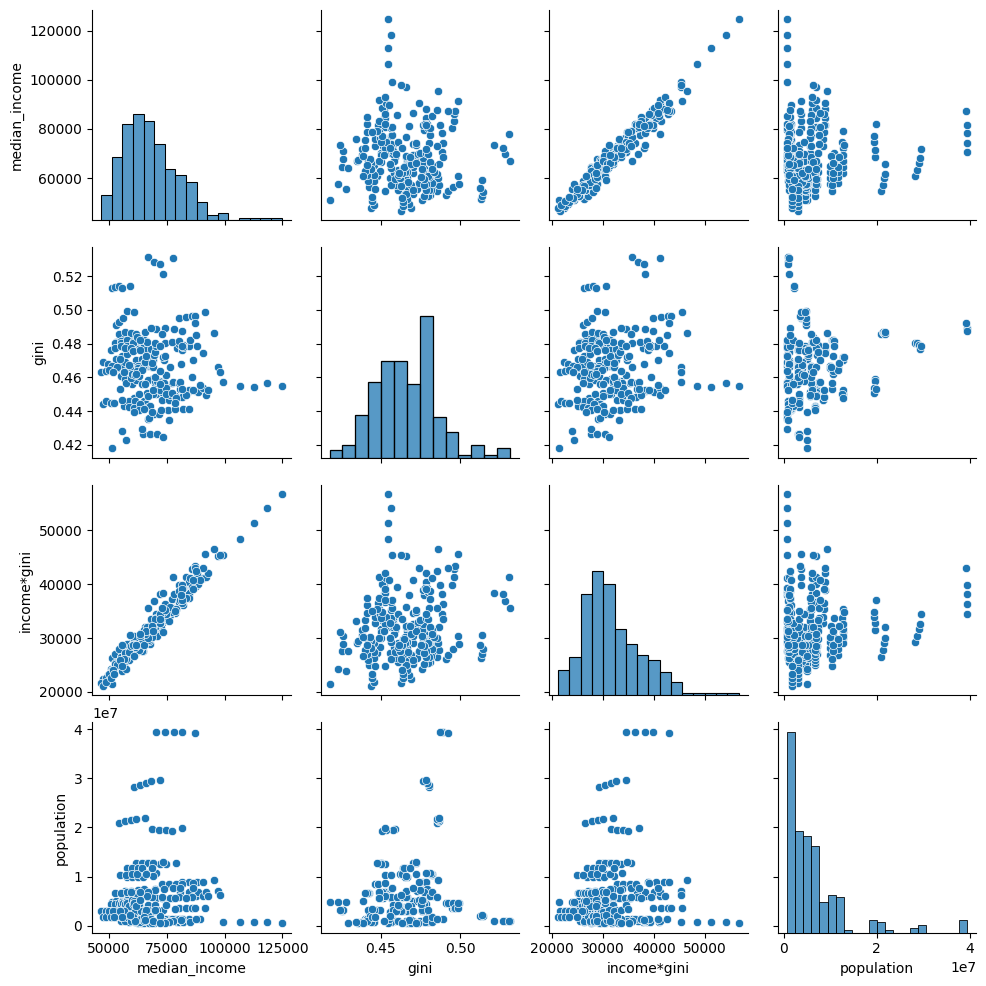

In [27]:
sns.pairplot(mdata_all[['median_income', 'gini', 'income*gini', 'population']])
plt.show()

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Income, GINI, Population
print("========== Income, GINI, Interaction, Population ==========")
X_train = mdata_all[['median_income', 'gini', 'income*gini', 'population']]
vif = pd.DataFrame()
vif['Column'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

print(vif, end='\n\n')

# Income, GINI, Population
print("========== Income, GINI, Interaction ==========")
X_train = mdata_all[['median_income', 'gini', 'income*gini']]
vif = pd.DataFrame()
vif['Column'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

print(vif, end='\n\n')

# Income, Population
print("============= Income, Interaction =============")
X_train = mdata_all[['median_income', 'income*gini']]
vif = pd.DataFrame()
vif['Column'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

print(vif, end='\n\n')


# GINI, Population
print("============== GINI, Interaction ==============")
X_train = mdata_all[['gini', 'income*gini']]
vif = pd.DataFrame()
vif['Column'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

print(vif, end='\n\n')

========== Income, GINI, Interaction, Population ==========
          Column         VIF
0  median_income  587.319078
1           gini   31.155068
2    income*gini  643.957615
3     population    1.840198

========== Income, GINI, Interaction ==========
          Column         VIF
0  median_income  577.378841
1           gini   30.837674
2    income*gini  631.736044

============= Income, Interaction =============
          Column         VIF
0  median_income  572.323937
1    income*gini  572.323937

============== GINI, Interaction ==============
        Column        VIF
0         gini  30.567693
1  income*gini  30.567693



### 2. 소득, 인구(X)와 혐오 범죄 수(Y) 사이의 상관 관계 분석

In [17]:
X = mdata_all[['median_income', 'population']]
y = mdata_all['hate_crime_case']

# OLS 모델을 따라 선형 회귀 분석 수행
results = sm.OLS(y, X).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:        hate_crime_case   R-squared (uncentered):                   0.631
Model:                            OLS   Adj. R-squared (uncentered):              0.628
Method:                 Least Squares   F-statistic:                              214.3
Date:                Sat, 03 Jun 2023   Prob (F-statistic):                    5.14e-55
Time:                        21:30:40   Log-Likelihood:                         -1644.6
No. Observations:                 253   AIC:                                      3293.
Df Residuals:                     251   BIC:                                      3300.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

### 3. 소득 격차, 인구(X)와 혐오 범죄 수(Y) 사이의 상관 관계 분석

In [18]:
X = mdata_all[['gini', 'population']]
y = mdata_all['hate_crime_case']

# OLS 모델을 따라 선형 회귀 분석 수행
results = sm.OLS(y, X).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:        hate_crime_case   R-squared (uncentered):                   0.621
Model:                            OLS   Adj. R-squared (uncentered):              0.618
Method:                 Least Squares   F-statistic:                              206.0
Date:                Sat, 03 Jun 2023   Prob (F-statistic):                    1.17e-53
Time:                        21:30:41   Log-Likelihood:                         -1647.8
No. Observations:                 253   AIC:                                      3300.
Df Residuals:                     251   BIC:                                      3307.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### 4. 소득 격차, 상호작용항(X)

In [78]:
mdata_noDC = mdata_all.drop(mdata_all[(mdata_all['state_name'] == "District of Columbia")].index)

X = mdata_noDC[['gini', 'income*gini', 'population']]
X = sm.add_constant(X)
y = mdata_noDC['hate_crime_case']

# OLS 모델을 따라 선형 회귀 분석 수행
results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        hate_crime_case   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     72.15
Date:                Sat, 03 Jun 2023   Prob (F-statistic):           2.94e-33
Time:                        23:25:44   Log-Likelihood:                -1574.8
No. Observations:                 243   AIC:                             3158.
Df Residuals:                     239   BIC:                             3172.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.8844    250.225      0.036      